In [3]:
# startup code for examples and visualisations
Pkg.add("QuadGK")
using QuadGK
using PyPlot: spy, plot_trisurf
using Plots

function trisurf(T, X, Z, colormap="jet")
    PyPlot.plot_trisurf(view(X,1,:), view(X,2,:), Z[:], triangles=T'-1, 
                        cmap=PyPlot.ColorMap(colormap), linewidth=0.5)
end

trisurf (generic function with 2 methods)


## Introduction to Finite Element Methods

<br>

### DST Module 4

<br>


### James Kermode

<b>j.r.kermode@warwick.ac.uk</b>

Warwick Centre for Predictive Modelling / School of Engineering

<table style="border-style: hidden;">
<tr>
<td style="border-right: none"><img src="images/WCPM_logo_text.png" width="250"></td>
<td style="border-left: none"><img src="images/dst-logo.png" width="250"></td>
</tr>
</table>

## Multiscale Materials Modelling

<img src="images/multiscale2.png" width="90%">

## Finite Element Analysis

<img align="right" width="30%" src="https://cdn.comsol.com/cyclopedia/finite-element-method/analysis-of-wheel-rim.png">

- Finite Element Analysis (FEA) or Finite Element Method (FEM) is a numerical method for solving continuum problems expressed as partial differential equations (PDEs) on a discrete mesh, e.g.

    - Mechanics for solids and structures
    - Heat transfer
    - Fluid flow
    - Soil mechanics
    - Electromagnetic fields

- Useful where analytical solutions can't easily be obtained, e.g. complicated geometries, loadings or material properties



## Further Reading

<table align="right" style="border-style: hidden;">
<tr>
<td style="border-right: none"><img src="https://images-na.ssl-images-amazon.com/images/I/414uq1O2NKL._SX349_BO1,204,203,200_.jpg" width="150px"></td>
<td style="border-left: none"><img src="http://secure-ecsd.elsevier.com/covers/80/Tango2/large/9780080531670.jpg" width="150px"></td>
</tr>
</table>

This lecture provides only a very brief introduction. Many good textbooks, including:

- Thomas J. R. Hughes *The Finite Element Method: Linear Static and Dynamic Finite Element Analysis*, Dover Publications (2000)
- O. C. Zienkiewicz, R. L. Taylor *The Finite Element Method, Sixth Edition*, Butterworth-Heinemann (2006)

**Note on examples:** I will use the [Julia](http://julialang.org/) language (similar to Python and Matlab) for simple examples.  Interactive slides on Moodle can be run using [JuliaBox](https://juliabox.com/) website.

## Historial Overview

<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/FAE_visualization.jpg/250px-FAE_visualization.jpg">

- Grew out of aerospace industry in 1950s: jets, missiles and space flight
    - Need for light weight structures
    - Accurate stress analysis
- Developed in 1960s and 70s, alongside high performance computing capabilites
- Now very widely used in academia and industry, with many commerial codes: ABAQUS, ANSYS, COMSOL, etc.
- Important to have understanding of fundamentals of approach, inputs and outputs, and strengths and limitations

## Principles of Finite Element Analysis

<img align="right" width="30%" src="http://charm.cs.uiuc.edu/ppl_manuals/old/fem/simple_mesh.png">

- Computational technique to obtain approximate solutions of **boundary value problems**

- Also known as **field problems**: field is domain of interest, representing physical structure.

- **Field variables** are dependent variables governed by a (partial) differential equation

- **Boundary conditions** are specified values of field variables (or e.g. their derivatives) on boundary of domain

## Shape functions

<img align="right" width="40%" src="linear-fe.png">

- Field variables are evaluated at **nodes**. Values inside **elements** are approximated by interpolation using **shape functions**

- Displacement within element interpolated between nodes 
$$
u(x) = \sum_i N_i(x) u_i = N_1(x)u_1 + N_2(x) u_2 = \boldsymbol{N} \boldsymbol{u}
$$
where $\boldsymbol{N} = [N_1\; N_2]$ and $\boldsymbol{u} = \left(u_1\; u_2\right)^T$.
- Boundary conditions: $u_1 = u(x=x_1), \; u_2 = u(x=x_2)$
$$\implies N_1(x_1) = 1,\; N_2(x_1) = 0,\;N_1(x_2) = 0,\; N_2(x_2) = 1$$

## Example - linear finite element shape functions

Displacement within 1D linear element
$u(x) = \sum_i N_i(x) u_i$

In [4]:
x1, x2 = 0.0, 1.0
u1, u2 = sin(x1), sin(x2)
x = linspace(x1, x2)
N_1 = 1 - (x - x1)/(x2 - x1)
N_2 = (x - x1)/(x2 - x1)
plot([N_1, sin(x), N_2, N_1*u1 + N_2*u2], layout=2,
    label=["N1(x)" "sin(x)" "N2(x)" "u(x)"], lw=2, size=(500,250), xlabel=:x)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] sin(::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:515
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.6/IJulia/src/execute_request.jl:160
 [5] eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.6/IJulia/src/eventloop.jl:8
 [6] (::IJulia.##11#14)() at ./task.jl:335
while loading In[4], in expression starting on line 6


## Finite element solution of differential equations

Many problems can be describe by an ordinary differential equation with a **strong form** similar to
$$
a\frac{\mathrm{d^2}u}{\mathrm{d}x^2} + b = 0,\; 0 \le x \le L
$$
with boundary conditions $u(x=0) = 0$ and $\left.a\frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=L} = R$.

Substituting $u(x) = \sum_i N_i(x) u_i = \boldsymbol{N}\boldsymbol{u}$ gives
$$
    a \frac{\mathrm{d^2}}{\mathrm{d}x^2} \left( \boldsymbol{N} \boldsymbol{u} \right) + b = \phi
$$
where the residual $\phi \ne 0$ due to piecewise linear approximation.

## Galerkin method:  find weak form of equation

We can use the Galerkin method to minimise the residual $\phi$, multiplying by $\boldsymbol{N}^T$, integrating over each element and equating to zero:
$$
    \int_{x_1}^{x_2} \left(
        \boldsymbol{N}^T a \frac{\mathrm{d^2}}{\mathrm{d}x^2} \left( \boldsymbol{N} \boldsymbol{u} \right) +
        \boldsymbol{N}^T b
    \right)\,\mathrm{d}x = 0
$$

Integrating by parts gives a discrete **weak form** of the differential equation including the boundary conditions
$$
    \left(\int_{x_1}^{x_2}
      \frac{\mathrm{d}\boldsymbol{N}}{\mathrm{d}x}^T a
      \frac{\mathrm{d}\boldsymbol{N}}{\mathrm{d}x}
    \,\mathrm{d}x \right)\boldsymbol{u}
    =  \int_{x_1}^{x_2}
    \boldsymbol{N}^T b
    \,\mathrm{d}x 
    + \left(\begin{array}{c} 0 \\ 1
    \end{array}\right) \left.a\frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=x_2}
    -
    \left(\begin{array}{c} 1 \\ 0
    \end{array}\right) \left.a\frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=x_1}
$$

## General form of finite element equations

The weak form for the element is usually written as
$\boldsymbol{k}_e \boldsymbol{u}_e = \boldsymbol{b}_e$,
where the elemental stiffness matrix and force array are given by

$$
\boldsymbol{k}_e = \int_{x_1}^{x_2}
\frac{\mathrm{d}\boldsymbol{N}}{\mathrm{d}x}^T
a \frac{\mathrm{d}\boldsymbol{N}}{\mathrm{d}x}
\mathrm{d} x
$$

and

$$
\boldsymbol{b}_e = \int_{x_1}^{x_2} \boldsymbol{N}^T b  \; \mathrm{d} x 
    + 
    \left(\begin{array}{c} 0 \\ 1
    \end{array}\right) \left.a\frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=x_2}
    -
    \left(\begin{array}{c} 1 \\ 0
    \end{array}\right) \left.a\frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=x_1}
$$

Assembling elemental stiffness matrices and forces vectors gives the global equation $\boldsymbol{K} \boldsymbol{u} = \boldsymbol{b}$.

## General steps in solving a problem using FEM

<table style="border:none; border-spacing: 10px; border-collapse: separate">
<tr>
<td style="padding: 15px; line-height: 36px; text-align: center; background: rgba(0,0,255,0.3)">Real World</td>
<td style="border:none">&#x2192;</td>
<td style="background: rgba(0,0,255,0.3); line-height: 36px; text-align: center">Simplified Physical Model</td>
<td style="border:none">&#x2192;</td>
<td style="background: rgba(0,0,255,0.3);line-height: 36px; text-align: center">Mathematical Model</td>
<td style="border:none">&#x2192;</td>
<td style="background: rgba(0,0,255,0.3); line-height: 36px; text-align: center">Discretised Model</td>
</tr>
</table>

1. **Preprocessing Phase**

2. **Solution Phase**

3. **Postprocessing Phase**

## 1. Preprocessing Phase

<img align="right" width="30%" src="https://upload.wikimedia.org/wikipedia/commons/8/80/Example_of_2D_mesh.png">

1. Discretize the problem domain, choose element type and interpolation functions
2. Assume solution that approximates the element behavior
3. Derive element stiffness matrix and element force equations
4. Assemble element equations into global equations
5. Introduce boundary conditions

## Examples of FEM element types - 1D, 2D, 3D

- 1D line elements: spring, truss, beam, etc.
- 2D plane elements: membrane, plate, shell, etc.
- 3D solid elements: for 3D fields e.g. temperature, displacement, stress, flow

<table style="border:none; border-spacing: 10px; border-collapse: separate">
<tr>
<td><img src="images/fem-1d.png" width="80%"></td>
<td><img src="images/fem-2d.png" width="80%"></td>
<td><img src="images/fem-3d.png" width="80%"></td>
</tr>
<tr>
</td>
</table>

## 2. Solution Phase

1. Solve for the unknown degrees of freedom
2. Back-substitute to compute additional derived quantities such as reaction forces

## 3. Postprocessing Phase

<img align = "right" width="30%" src="https://upload.wikimedia.org/wikipedia/commons/7/7b/FEM_example_of_2D_solution.png">

1. Find element strains and stresses and other important information
2. Interpret results



## Example - 1D elastic bar

Governing differential equation 
$$
\frac{\mathrm{d}}{\mathrm{d}x}\left[ EA \frac{\mathrm{d}u}{\mathrm{d}x} \right] + f(x) = 0
$$
with boundary conditions $u(0)=0, \left. EA \frac{\mathrm{d}u}{\mathrm{d}x}\right|_{x=L}=0$. If $E$ and $A$ are constant this is a special case of general FE equation with $a  = EA$ and $b = f(x)$. 

The problem can be recast as finite element problem $\boldsymbol{K} \boldsymbol{u} = \boldsymbol{b}$ where $\boldsymbol{K}$ is global stiffness matrix, and $\boldsymbol{u}$ and $\boldsymbol{b}$ are global displacement and force vectors, respectively.

## 1.1 Preprocessing - defining a mesh

We will create a mesh of length $L$ with a prescribed number of cells (elements) $n_{\text{cells}}$. For linear elements, the number of nodes $n_{\text{nodes}}$ is equal to $n_{\text{cells}} + 1$. We use an array of equally spaced points on the interval $[0, L]$ at intervals of $h=L/n_\text{cells}$.

In [5]:
L = 10.0
n_cells = 10
n_nodes = n_cells + 1
h = L/n_cells

mesh = linspace(0.0, L, n_nodes)
plot(mesh, zeros(mesh), marker=:o, ms=10, lw=5, ylims=(-1,1), 
     grid=false, legend=false, size=(600, 200))

## 1.2 Approximate model for element behaviour

<img align="right" width="40%" src="images/spring-element.png">

- Model each element as an elastic spring of natural length $h$ 
- Each spring has two nodal displacements, $u_1$ and $u_2$. 
- The force-extension relation is given by constitutive equation
$$
  \sigma = E \epsilon = E \frac{\mathrm{d}u}{\mathrm{d}x}
$$

## 1.2 Approximate model for element behaviour

- Spring force can be obtained using Hooke's Law
$$
f = k \delta = k (u_2 - u_1)
$$
Using $\sigma = E\epsilon$ gives
$$
\frac{f}{A} = E \frac{\delta}{h} \implies f = \left(\frac{EA}{h} \right) \frac{\mathrm{d}u}{\mathrm{d}x}
\implies k = \frac{EA}{h}
$$

## 1.3 Element stiffness matrix $\boldsymbol{k}_{e}$


- Could obtain $\boldsymbol{k}_e$ using integral formula, but we'll use a physical argument. In equilibrium, $f_1 + f_2 = 0$ i.e.
$$
f_1 = -k (u_2 - u_1) \;\text{and}\;
f_2 = k (u_2 - u_1)
$$

- In matrix form: $\boldsymbol{k}_e \boldsymbol{u}_e = \boldsymbol{f}_e$ with element stiffness matrix

$$
\boldsymbol{k}_{e} =
\begin{bmatrix}
k & -k \\ -k & k    
\end{bmatrix}
= \frac{EA}{h}
\begin{bmatrix}
1 & -1 \\ -1 & 1    
\end{bmatrix}
$$

In [6]:
E = 100.0
A = 1.0
k_e = (E*A/h)*[1 -1; 
              -1  1];

## 1.4 Assemble global stiffness matrix

- To build the global stiffness matrix $\boldsymbol{K}$, we create an empty $n_{\text{nodes}} \times n_{\text{nodes}}$ matrix

- Then loop over each cell and add the cell contribution $\boldsymbol{k}_{e}$ to the the global matrix $\boldsymbol{K}$

In [7]:
K = zeros(n_nodes, n_nodes)

for element in 1:n_cells
    K[element:element + 1, element:element + 1] += k_e
end

In [8]:
heatmap(K, yflip=true)

## 1.4 Create force vector $\boldsymbol{b}$

- Distributed load $f(x)$ can vary with position
- Create global RHS vector $\boldsymbol{b}$ by adding the cell $\boldsymbol{b}_{e}$ 
- Integrate RHS using the midpoint rule
$$
\boldsymbol{b}_e = \left(\begin{array}{c}
\int_{x_{i}}^{x_{i+1}} N_{1}(x) f(x) \,\mathrm{d}x \\
\int_{x_{i}}^{x_{i+1}} N_{2}(x) f(x) \,\mathrm{d}x
\end{array}
\right) \approx
\left(\begin{array}{c}
\frac{h}{2}f\left((x_{i} + x_{i+1})/2\right) \\
\frac{h}{2}f\left((x_{i} + x_{i+1})/2\right) \\
\end{array}
\right)
$$

In [9]:
distributed_load(x) = 1.0 # function for loading, here constant ∀ x
b = zeros(n_nodes)
for element in 1:n_cells
    h     = mesh[element+1] - mesh[element]   
    x_mid = (mesh[element+1] + mesh[element])/2.0    
    f = distributed_load(x_mid)
    b[element:element + 1] += 0.5*h*f
end

## 1.5 Apply Dirichlet boundary conditions

- Almost ready to solve problem, but stiffness matrix is singular:

In [10]:
det(K)

0.0

- We have not applied a Dirichlet (displacement) boundary condition

- Impose boundary condition $u(0) = 0$ by zeroing the first row and column of the matrix, placing a one on the first diagonal entry and setting the first entry on the RHS to zero. 

In [11]:
K[1, :] = 0.0
K[:, 1] = 0.0
K[1, 1] = 1.0
b[1] = 0.0
det(K)

9.999999999999982e19

In [12]:
heatmap(K, yflip=true)

## 2. Solve linear system of equations

- Solve $\boldsymbol{K} \boldsymbol{u} = \boldsymbol{b}$ to get the nodal degrees-of-freedom $\boldsymbol{u}$.
- Could invert matrix and use $\boldsymbol{u}  = \boldsymbol{K}^{-1} \boldsymbol{b}$, but computationally cheaper and more robust to solve for specific RHS

In [13]:
u = K \ b
println(u)

[0.0, 0.095, 0.18, 0.255, 0.32, 0.375, 0.42, 0.455, 0.48, 0.495, 0.5]


- This is a direct solver for a dense matrix. $\boldsymbol{K}$ is mostly zero, so a **sparse** linear algebra solver is usually used to reduce memory. 
- **Iterative** solvers such as adaptive multigrid methods further reduce computational cost.

## 3. Post-processing: visualising the solution


In [14]:
plot(mesh, u, marker=:o, xlabel=:x, lw=5, ylabel=:u, leg=false, 
     grid=false, title="Finite element solution for the elastic bar")

## Derived nodal quantities

Now we have the displacements $u$, can compute strain $\epsilon = \delta/l$ and stress $\sigma = E \epsilon$ for each node.

In [15]:
ϵ = (u[2:end] - u[1:end-1]) / h
σ = E * ϵ

plot(mesh[1:end-1], [ϵ σ], layout=2, legend=false, size=(600,300),
     ylabel=[:Strain :Stress], xlabel=:x, marker=:o, lw=3)

## Programmatic approach

In [22]:
function solver(L, f, n_cells; quad_degree=3)
    n_nodes = n_cells + 1
    mesh = linspace(0.0, L, n_nodes)
    h = L/n_cells
    k_e = (E*A/h)*[ 1 -1; -1 1]
    K = zeros(n_nodes, n_nodes)
    for element in 1:n_cells
        K[element:element + 1, element:element + 1] += k_e
    end
    quad_points, quad_weights = gauss(Float64, quad_degree)
    b = zeros(n_nodes)
    for element in 1:n_cells
        x_mid = (mesh[element + 1] + mesh[element])/2.0    
        for (zeta, weight) in zip(quad_points, quad_weights)    
            x = x_mid + zeta*h/2.0
            w = weight*(h/2.0)
            b[element] += w*(0.5 - zeta/2.0)*f(x) 
            b[element + 1] += w*(0.5 + zeta/2.0)*f(x)
        end
    end
    K[1, :], K[:, 1], K[1, 1] = 0.0, 0.0, 1.0
    b[1] = 0.0
    return K \ b, mesh
end

INFO: Package QuadGK is already installed


solver (generic function with 1 method)

## Sources of error
 
- Domain approximation error due to mesh
- Computational errors due to quadrature and finite arithmetic
- Approximation errors due to piecewise linear solution
- Two methods of refinement:
    - **$h$-refinement**, where we increase the number of elements in the domain
    - **$p$-refinement**, where the element size is unchanged but accuracy of numerical integration is increased

## Mesh spacing refinement

Compute solutions for increasingly fine meshes with $f(x) = \sin(x)$

In [23]:
meshes = [3, 5, 10, 20]
solutions = [solver(L, sin, n, quad_degree=3) for n in meshes]
plot(title="Mesh size dependence")
for (u, mesh) in solutions
    plot!(mesh, u, marker=:o, lw=3, ms=5, grid=false, label="$(length(mesh)-1) cells", size=(600,300))
end
current()

In [24]:
last_u, last_mesh = solutions[end]
err = [ abs(u[end] - last_u[end]) for (u, mesh) in solutions[1:end-1] ]
hs = [mesh[2] - mesh[1] for (u, mesh) in solutions[1:end-1] ]

plot(hs, err, lw=3,
     marker=:o, ms=5, leg=false, yscale=:log10, xscale=:log10,
     xlabel="log h", ylabel="log error")

## Quadrature accuracy convergence

$\int_{x_i}^{x_{i+1}} N(x) f(x)\, \mathrm{d}x$ performed with Gaussian quadrature. Can increase number of integration points: order $n$ is exact for polynomials of degree $n$.

In [25]:
orders = [1, 2, 3, 4]
solutions = [solver(L, sin, 10, quad_degree=order) for order in orders];
plot(title="p-convergence")
for ((u, mesh), order) in zip(solutions, orders)
    plot!(mesh, u, lw=3, ms=5, marker=:o, label="Order $(order)", 
    size=(600,200))
end
current()

In [26]:
last_u, last_mesh = solutions[end]
err = [ abs(u[end] - last_u[end]) for (u, mesh) in solutions ]
plot(orders[1:end-1], err[1:end-1], lw=3,
     marker=:o, leg=false, yscale=:log10,
     xlabel=:Order, ylabel=:Error)

## Generalising the Finite Element Method

Many problems can be describe by the differential equation with the **strong form**

$$
\frac{\mathrm{d}}{\mathrm{d}x}\left(
a \frac{\mathrm{d}u}{\mathrm{d}x}
\right) - cu + q = 0
$$
subject to boundary conditions $u(0) = u_0$, $\left[ a \frac{\mathrm{d}u}{\mathrm{d}x} \right]_{x=L} = Q_0$

## Weak Form of the Governing Equation

Multiplying by an unknown weight function $w(x)$ and integrating by parts leads to **weak form** of governing equation

$$
\int_{0}^{L} \left(
a \frac{\mathrm{d}u}{\mathrm{d}x}
\frac{\mathrm{d}w}{\mathrm{d}x} + cwu - wq
\right) \mathrm{d}x - \left.wQ\right|_{0} - \left.wQ\right|_{L} = 0
$$

where $Q = a \frac{\mathrm{d}u}{\mathrm{d}x} n_x$ is a secondary variable and $n_x$ are the direction cosines: in 1D these are $n_x(0) = -1, n_x(L)= +1$. Substituting $w(x) = N_i(x)$ for each shape function in turn recovers Galerkin method for minimising resisdual.

## Example Applications

$$
\frac{\mathrm{d}}{\mathrm{d}x}\left(
a \frac{\mathrm{d}u}{\mathrm{d}x}
\right) - cu + q = 0
\;\text{with BCs}\; u(0) = u_0, \left[ a(x) \frac{\mathrm{du}}{\mathrm{d}x} \right]_{x=L} = Q_0
$$

<img width="80%" src="https://github.com/tjfulle/fem-with-python/raw/ff55de94475de382f916a8483c84dc2d300fcd0e/Lessons/Images/weak.d/table-of-apps.png">

## Heat Conduction

<img src="https://github.com/tjfulle/fem-with-python/raw/ff55de94475de382f916a8483c84dc2d300fcd0e/Lessons/Images/strong.d/heat-1.png" width="80%" align="center">

Here $s(x)$ is heat generated, $q(x)$ is heat flux. Energy balance gives:
$$
s\left(x + \frac{\Delta x}{2}\right) + q(x)A(x) - q(x + \Delta x)A(x + \Delta x) = 0
$$

The **constitutive equation** is Fourier's law of heat conduction
$$
q = -k \frac{\mathrm{d}T}{\mathrm{d}x}
$$

Rearranging and taking the limit as $\Delta x \to 0$ gives
$$
\frac{\mathrm{d}}{\mathrm{d}x}\left(
kA \frac{\mathrm{d}T}{\mathrm{d}x}
\right) + s(T,x) = 0
$$

with boundary conditions $T(0) = T_0,\; q_0 = -k \frac{\mathrm{d}T}{\mathrm{d}x}$ at $x=L$.

This is in the required form for a Finite Element Method numerical solution.

## Time-dependent Solutions

So far all the problems we've looked at have been **static**. Considering a time-dependent temperature distribution leads to the **partial differential equation**

$$
\rho C_p \frac{\partial T}{\partial t} +
\frac{\partial}{\partial x}\left(
- k \frac{\partial T}{\partial x}
\right) = s(T,t,x)
$$

where $\rho$ and $C_p$ are the material density and heat capacity.

This equation can also be solved by the FEM approach, by discretising in time as well as in space.

## Beyond One Dimension

Method can be extended to more realistic problems, for example a mathematical model of a heat sink

$$
\rho C_p \frac{\partial T}{\partial t} +
\nabla \cdot \left(
- k \nabla T
\right) = s(T,t,\boldsymbol{x})
$$

in $\Omega$ subject to BCs $T = T_0$ on $\partial \Omega_1$, normal heat flux $(-k \nabla T)\cdot\boldsymbol{n}$ $= h(T - T_\mathrm{amb})$ on $\partial \Omega_2$ and $(-k \nabla T)\cdot\boldsymbol{n} = 0$ on $\nabla\Omega_3$.

<table style="border-style: hidden;">
<tr>
<td style="border-right: none"><img width="70%" src="https://cdn.comsol.com/cyclopedia/finite-element-method/heat-sink-model.png"></td>
<td style="border-left: none"><img width="70%" src="https://cdn.comsol.com/cyclopedia/finite-element-method/temperature-field-heat-sink-model.png"></td>
</tr>
</table>

## Summary of Finite Element Method

- The finite element method can be used to solve a wide range of PDEs numerically
- Main steps:
    1. Pre-processing: define mesh and element model, assembly global stiffness matrix
    2. Solve: using a direct or iterative method
    3. Post-process to extract desired output quantities
- 1D problems can be hand-coded, but generally best to use a commerical code for more complex problems: more on this in COMSOL workshops.

## FEM Inputs and Outputs

- User Inputs:
    - PDE and boundary conditions
    - Domain, mesh and element types
    - Constituitive equation defining material properties
- FEM Outputs:
    - Primary field quantity at nodes and within elements (e.g. displacement, temperature)
    - Secondary (derived) quantities (e.g. stress, heat flux)

## Strengths and Limitations

**Strengths:**
- Ideal for problems where physics is well understood but geometry is complex
- Wide range of PDEs and boundary conditions can be modelled
    
**Limitations:**
- FEM produces approximate solutions with inherent errors
- Only as good as physics used in approximate element models
- Mesh spacing and integration order must be carefully tested
- Prone to "user error": easy to produce beautiful but meaningless plots

## Demonstration 2D FEM code

If time allows, we will discuss a simple 2D code to solve the equation

$$\begin{align*}
 - \nabla^2 u &= 1, \quad  x \in \Omega \\
  u &= 0, \quad x \in \partial \Omega_\mathrm{D}, \\
  \nabla u \cdot \boldsymbol{n} &= 0, \quad x \in \partial\Omega_\mathrm{N}.
\end{align*}$$

This represents a simplification of the static heat transfer problem above.

### Mesh Generation

First we need to create a triangular mesh

In [27]:
function mesh2d(N)
    X = linspace(0, 1, N+1) * ones(1, N+1)
    X = [X[:]'; X'[:]']
    T = zeros(Int, 3, 2*N^2)
    idx = 0
    for icol = 1:N, irow = 1:N
        a = (icol-1)*(N+1)+irow
        idx += 1; T[:,idx] = [a; a+1; a+N+2]
        idx += 1; T[:,idx] = [a; a+N+2; a+N+1]
    end
    Ifree = find((X[1,:] .> 0) & (X[1,:] .< 1) & (X[2,:] .< 1))
    return X, T, Ifree
end

mesh2d (generic function with 1 method)

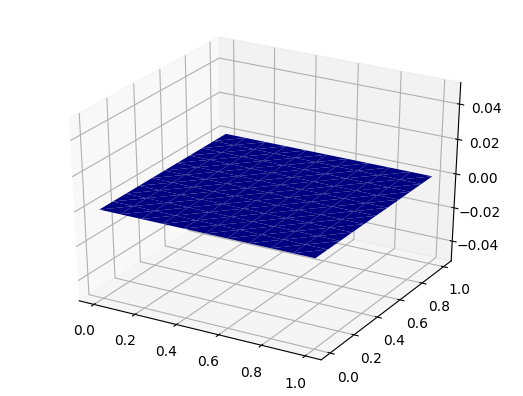

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] &(::BitArray{1}, ::BitArray{1}) at ./deprecated.jl:57
 [3] mesh2d(::Int64) at ./In[27]:11
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.6/IJulia/src/execute_request.jl:160
 [6] eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##11#14)() at ./task.jl:335
while loading In[28], in expression starting on line 1


PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f5a6e004990>

In [28]:
X, T, Ifree = mesh2d(10)
trisurf(T, X, zeros(X))

### Assembly of Stiffness Matrix

The next ingredient is the stiffness matrix $\boldsymbol{K}$. This time we use a sparse matrix, and have to transform| from element to global coordinate system.

In [29]:
function simple_stiffmat(X, T)
    nT = size(T, 2); nP = size(X, 2); dim = size(X, 1)
    facdim = factorial(dim)
    D = vcat(-ones(1, dim), eye(dim)) # grad operator
    F = zeros(nP)                     # rhs
    It = Int[]; Jt = Int[]; Vt = Float64[]
    idx = 0
    for k = 1:nT
        J = X[:, T[:, k]] * D # Jacobian
        B = D / J # transformed local stiffness matrix
        A = det(J)/facdim * B * B'
        for i = 1:(dim+1), j = 1:(dim+1)
            push!(It, T[i,k])
            push!(Jt, T[j,k])
            push!(Vt, A[i,j])
        end
        F[T[:,k]] += det(J)/facdim/(dim+1)  # assemble RHS for f(x)=1
    end
    return sparse(It, Jt, Vt, nP, nP), F
end

simple_stiffmat (generic function with 1 method)

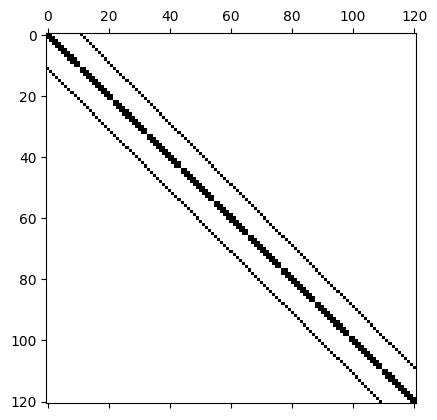

PyObject <matplotlib.image.AxesImage object at 0x7f5a6579a2d0>

In [30]:
A, F = simple_stiffmat(X, T)
spy(A)

### Boundary Conditions

We impose BCs by removing rows and columns corresponding to fixed nodes.

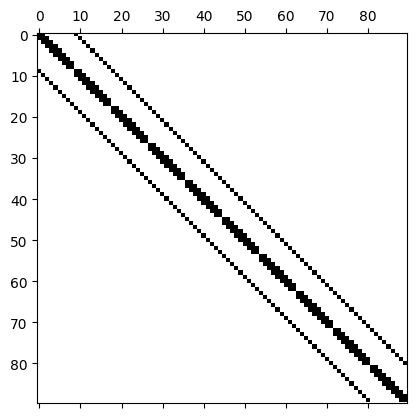

PyObject <matplotlib.image.AxesImage object at 0x7f5a614cba10>

In [31]:
spy(A[Ifree,Ifree])

### Solve and postprocess

We solve the sparse linear system and plot the solution for $u(x,y)$

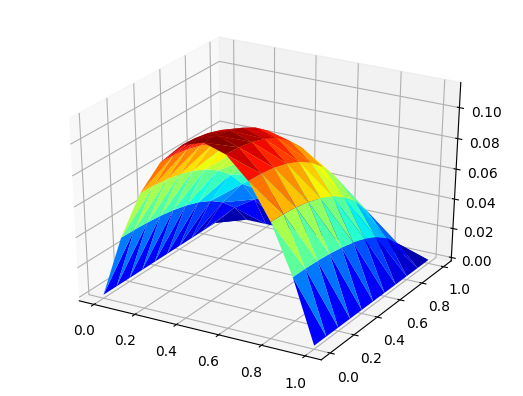

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7f5a613ecdd0>

In [32]:
U = zeros(size(X,2))
U[Ifree] = A[Ifree,Ifree] \ F[Ifree]
trisurf(T, X, U)